<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/timeSeriesKMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Install tslearn and kneed for time series clustering
!pip install tslearn
!pip install kneed

     |████████████████████████████████| 793 kB 9.8 MB/s 


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.matlib

from tslearn.metrics import dtw_path
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from tslearn.clustering import TimeSeriesKMeans

%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:.4f}'.format #Change display format in DataFrame table

In [ ]:
# Import data
df = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroTransformed.csv',
    index_col = ['Date']
)

# Extra example from dataset
n = 30
df = df.sample(n, axis = 1)
df.head(5)

,HD_M9_lg8,API_lg8,FDI_M9_lg4,CCI_M12_lg5,RSI_LN_lg5,PIR_M6_lg4,HD_C_lg7,PIR_M3_lg7,UR_LN_lg2,PCI_M3_lg2,HD_LN_lg3,MPI_C_lg11,PCI_C_lg3,API_M12_lg7,PII_M3_lg3,MPI_C,PII_M6_lg7,PIR_C_lg8,MPI_M9_lg1,UR_lg5,API_M6_lg5,Ex_M3_lg7,Im_M3_lg10,FDI_lg10,GDP_M3_lg1,RSI_lg7,PII_C_lg11,Ex_M12_lg8,FDI_lg6,CPI_C_lg11
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,7714968.7399,154.2877,190907.6223,36.2083,5.4007,2.5417,0.1306,2.5833,-0.3285,112.4467,15.9379,0.1193,0.0023,151.3375,131.2367,-0.1163,125.3967,-0.5000,101.0957,0.8100,151.2666,559056.5300,593792.8367,194863.8300,2286182.5633,225.4400,0.0293,583725.6983,189110.8792,0.0318
2014-02-01,7797697.6288,152.9524,191517.8708,36.6000,5.3804,2.5000,0.1288,2.5000,-0.4780,110.7500,15.9494,0.1435,-0.0044,151.1923,138.5833,-0.0589,125.7950,-0.5000,101.7663,0.6700,152.0570,586937.2333,567183.2600,194088.2649,2337236.7625,220.7100,-0.0010,580709.4025,191241.7602,0.0264
2014-03-01,7872636.9608,150.6148,191168.9390,36.7417,5.3687,2.4583,0.1256,2.5000,-0.0619,112.7200,15.9581,0.0899,-0.0038,151.4196,143.9967,-0.0887,126.9250,-0.5000,100.8775,0.6200,152.6040,603812.0367,582898.4167,190972.1930,2373802.9114,221.5600,0.0042,579335.7742,192391.0000,0.0239
2014-04-01,7937978.0217,151.9438,190333.3723,36.6167,5.3775,2.4167,0.1203,2.5000,-0.1508,107.2633,15.9626,0.0464,-0.0133,151.5582,136.3633,-0.0512,125.1483,-0.5000,101.3991,0.7200,152.2178,613042.6200,584699.1467,188528.5600,2388518.9114,217.1100,-0.0387,580932.3667,190928.2877,0.0224
2014-05-01,7998612.0217,153.3119,189814.3580,36.4667,5.4512,2.3750,0.1131,2.5000,-0.1278,110.8533,15.9645,0.0259,-0.0045,151.3995,126.4800,-0.0631,129.2733,-0.5000,99.7629,0.6200,152.6303,616027.0000,584496.0800,189110.8792,2376649.3670,214.5800,-0.0440,579094.9700,188395.6756,0.0223


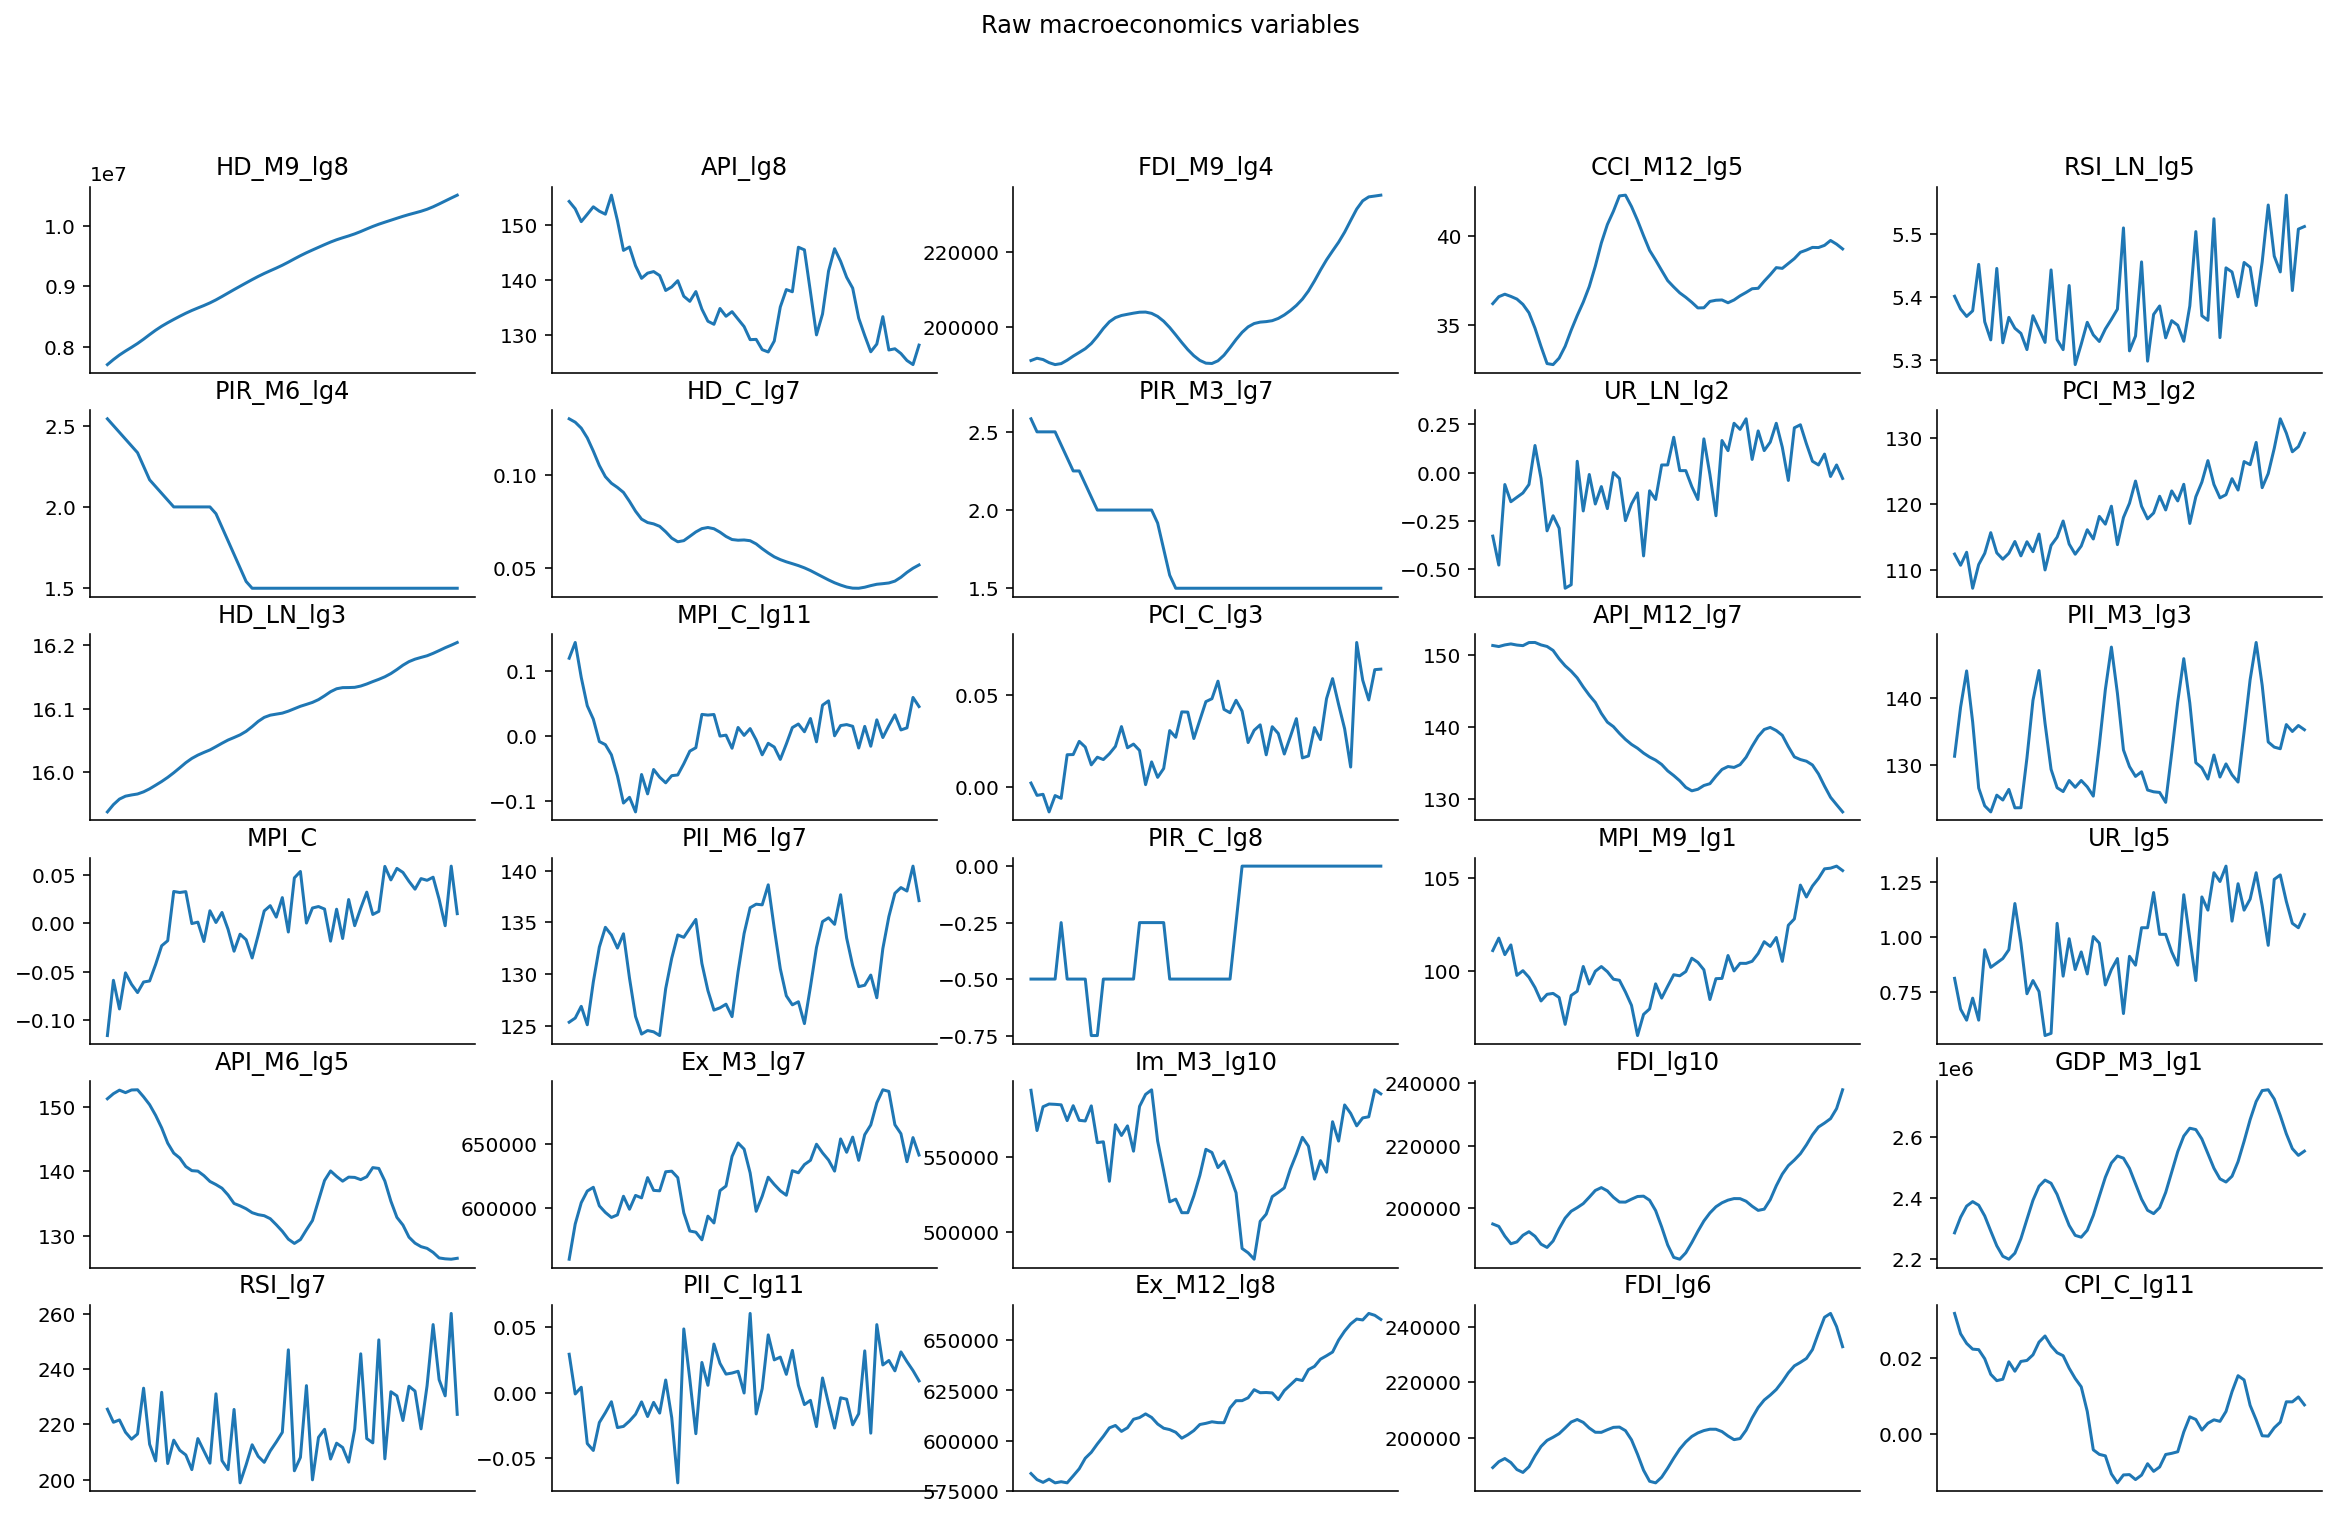

In [ ]:
# Visualization
# Define plot style
plotStyle = {
    "axes.spines.left" : True,
    "axes.spines.right" : False,
    "axes.spines.bottom" : True,
    "axes.spines.top" : False,
    "axes.grid" : False,
    "xtick.bottom" : True,
    "ytick.left" : True,
}

# Plot
with plt.style.context(plotStyle):
  fig, axs = plt.subplots(6, 5, figsize = (20, 12), sharex = True)
  axs = axs.ravel()
  fig.suptitle('Raw macroeconomics variables')
  for i, var in enumerate(df.columns):
    axs[i].plot(df[var])
    axs[i].set_title(f'{var}')
    axs[i].set_xticks([])
plt.show()

## The time series K-Means
In the K-Means algorithm, it is usually leveraged the 'Euclidean Distance' but it can be seen that it is not effective in time series cases. Therefore, the Dynamic Time Warping (DTW) will be adopted instead of the Euclidean Distance.The following images will be shown the comparison between these two algorithms.

![Euclidean Distance and Dynamic Time Warping](https://rtavenar.github.io/blog/fig/dtw_vs_euc.svg)

In [ ]:
# Standardization 
scalar = StandardScaler()
dfSTD = scalar.fit_transform(df).T #Transpose date time to column
print(f'Number of variables: {dfSTD.shape[0]}\nNumber of time: {dfSTD.shape[1]}')

Number of variables: 30
Number of time: 59


In [ ]:
# Create data for plot
dfPlot = pd.DataFrame(
    scalar.fit_transform(df),
    columns = df.columns,
    index = df.index
)
dfPlot.head(5)

,HD_M9_lg8,API_lg8,FDI_M9_lg4,CCI_M12_lg5,RSI_LN_lg5,PIR_M6_lg4,HD_C_lg7,PIR_M3_lg7,UR_LN_lg2,PCI_M3_lg2,HD_LN_lg3,MPI_C_lg11,PCI_C_lg3,API_M12_lg7,PII_M3_lg3,MPI_C,PII_M6_lg7,PIR_C_lg8,MPI_M9_lg1,UR_lg5,API_M6_lg5,Ex_M3_lg7,Im_M3_lg10,FDI_lg10,GDP_M3_lg1,RSI_lg7,PII_C_lg11,Ex_M12_lg8,FDI_lg6,CPI_C_lg11
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,-1.9551,1.9424,-0.9775,-0.5861,0.1387,2.4612,2.6902,2.3289,-1.4509,-1.0697,-1.9172,2.5182,-1.3378,1.6173,-0.1295,-3.0664,-1.3294,-0.9108,0.2726,-0.8023,1.7897,-2.2977,1.4077,-0.5808,-1.1868,0.4452,1.0652,-1.3719,-1.0562,2.0341
2014-02-01,-1.8510,1.7848,-0.9302,-0.4085,-0.1704,2.3342,2.6139,2.0932,-2.1970,-1.3500,-1.7659,3.0173,-1.6879,1.5973,0.9755,-1.5862,-1.2393,-0.9108,0.5840,-1.5203,1.8930,-1.3140,0.4807,-0.6446,-0.8240,0.1064,-0.1226,-1.5001,-0.9163,1.5850
2014-03-01,-1.7568,1.5088,-0.9572,-0.3443,-0.3489,2.2073,2.4797,2.0932,-0.1203,-1.0246,-1.6514,1.9103,-1.6577,1.6286,1.7896,-2.3535,-0.9840,-0.9108,0.1713,-1.7767,1.9645,-0.7186,1.0282,-0.9009,-0.5642,0.1673,0.0794,-1.5584,-0.8409,1.3720
2014-04-01,-1.6746,1.6657,-1.0219,-0.4010,-0.2139,2.0804,2.2606,2.0932,-0.5642,-1.9261,-1.5909,1.0127,-2.1582,1.6477,0.6416,-1.3878,-1.3855,-0.9108,0.4135,-1.2638,1.9140,-0.3929,1.0909,-1.1019,-0.4596,-0.1514,-1.6049,-1.4906,-0.9369,1.2455
2014-05-01,-1.5983,1.8272,-1.0621,-0.4690,0.9084,1.9534,1.9621,2.0932,-0.4495,-1.3330,-1.5660,0.5895,-1.6938,1.6258,-0.8449,-1.6936,-0.4532,-0.9108,-0.3463,-1.7767,1.9679,-0.2876,1.0838,-1.0540,-0.5439,-0.3326,-1.8116,-1.5686,-1.1031,1.2339


In [ ]:
# Dynamic Time Warping (DTW)
# Define plot function
def plotDTW(series1, series2):
  name1, name2 = series1.name, series2.name
  series1, series2 = np.array(series1).reshape((-1, 1)), np.array(series2).reshape((-1, 1))
  path, simScore = dtw_path(series1, series2) #Compare to time series data

  # Compute distance between each pair
  dist = cdist(series1, series2)

  # Define plot area
  plt.figure(1, figsize = (9, 9))
  plotArray = np.arange(series1.shape[0])
  xS = [j for (i, j) in path] #List of path for second series
  yS = [i for (i, j) in path] #List of path for first series
  axDist = plt.axes([0.21, 0, 0.7, 0.7])
  axX = plt.axes([0.21, 0.72, 0.7, 0.2])
  axY = plt.axes([0, 0, 0.2, 0.7])

  # Plot
  axDist.imshow(
      dist,
      origin = 'lower',
      cmap = 'winter'
  )
  axDist.axis('off')
  axDist.plot(
      xS,
      yS,
      c = 'white',
      linewidth = 3,
      linestyle = '--',
      label = f'Sum of distances: {simScore:.4f}'
  )
  axDist.legend(frameon = True, facecolor = 'white')
  axDist.set_title('Dynamic Time Warping')

  axX.plot(
      plotArray,
      series2,
      c = 'darkblue',
      linewidth = 3
  )
  axX.set_title(f'{name2}')
  axX.axis('off')

  axY.plot(
      -series1,
      plotArray,
      c = 'forestgreen',
      linewidth = 3
  )
  axY.set_ylabel(f'{name1}')
  axY.set(xticks = [], yticks = [])
  axY.spines['left'].set_visible(False)
  axY.spines['right'].set_visible(False)
  axY.spines['top'].set_visible(False)
  axY.spines['bottom'].set_visible(False)
  return plt.show()

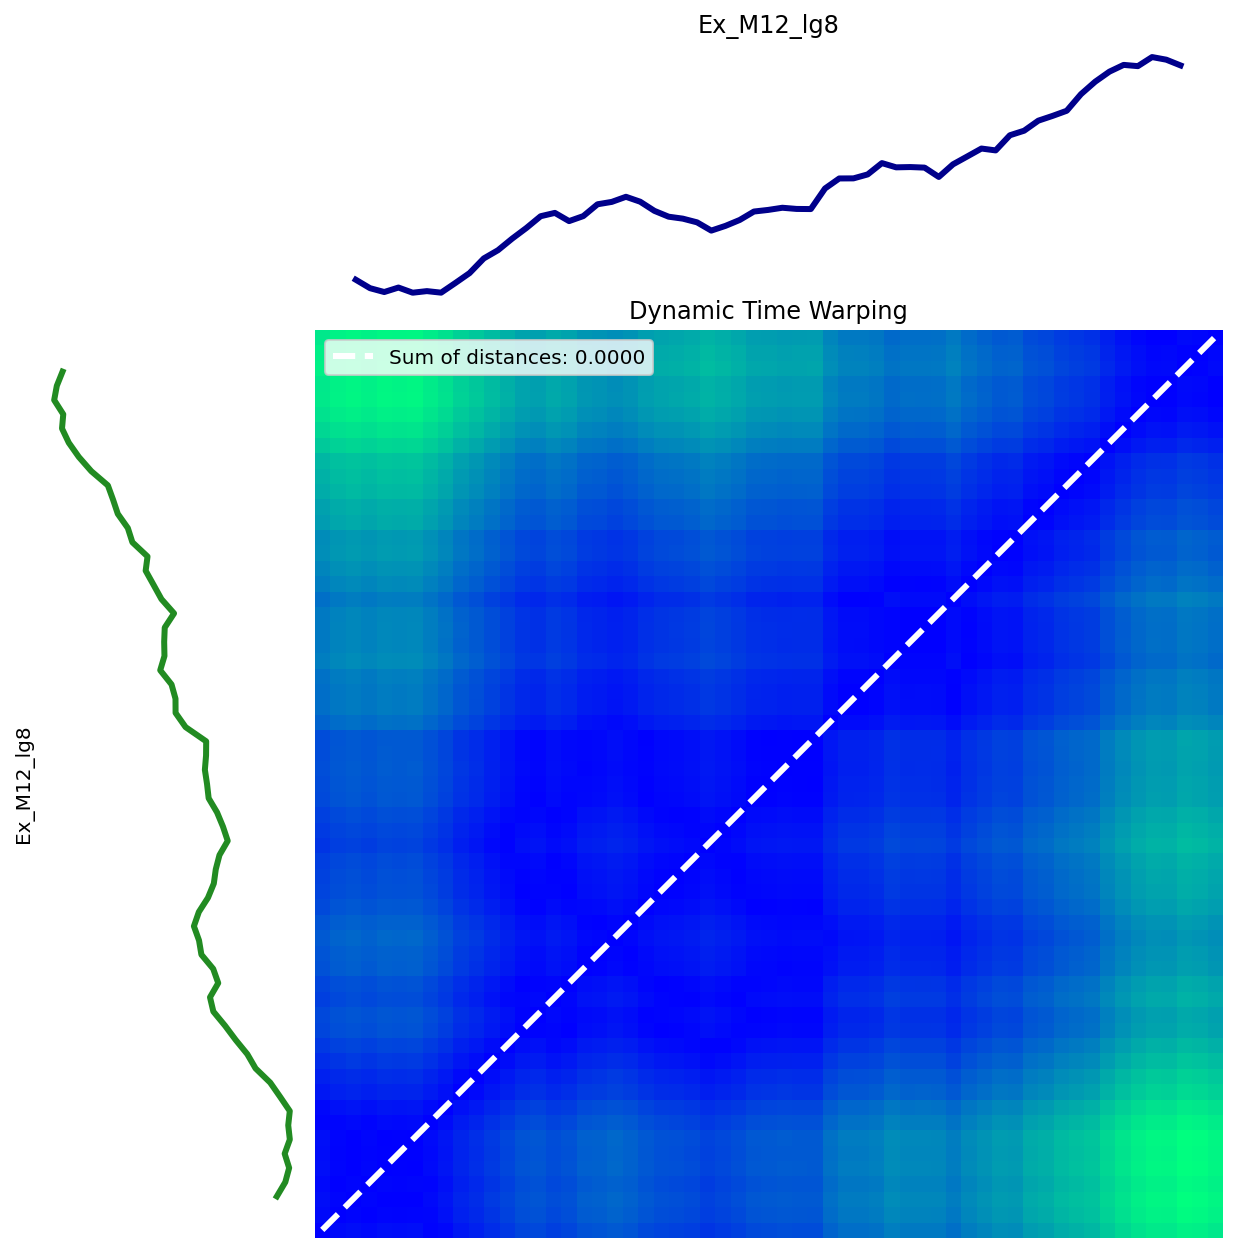

In [ ]:
# Plot similar variable
plotDTW(
    dfPlot.sample(
        1,
        axis = 1,
        random_state = 42
    ).iloc[:, 0],
    dfPlot.sample(
        1,
        axis = 1,
        random_state = 42
    ).iloc[:, 0]
)

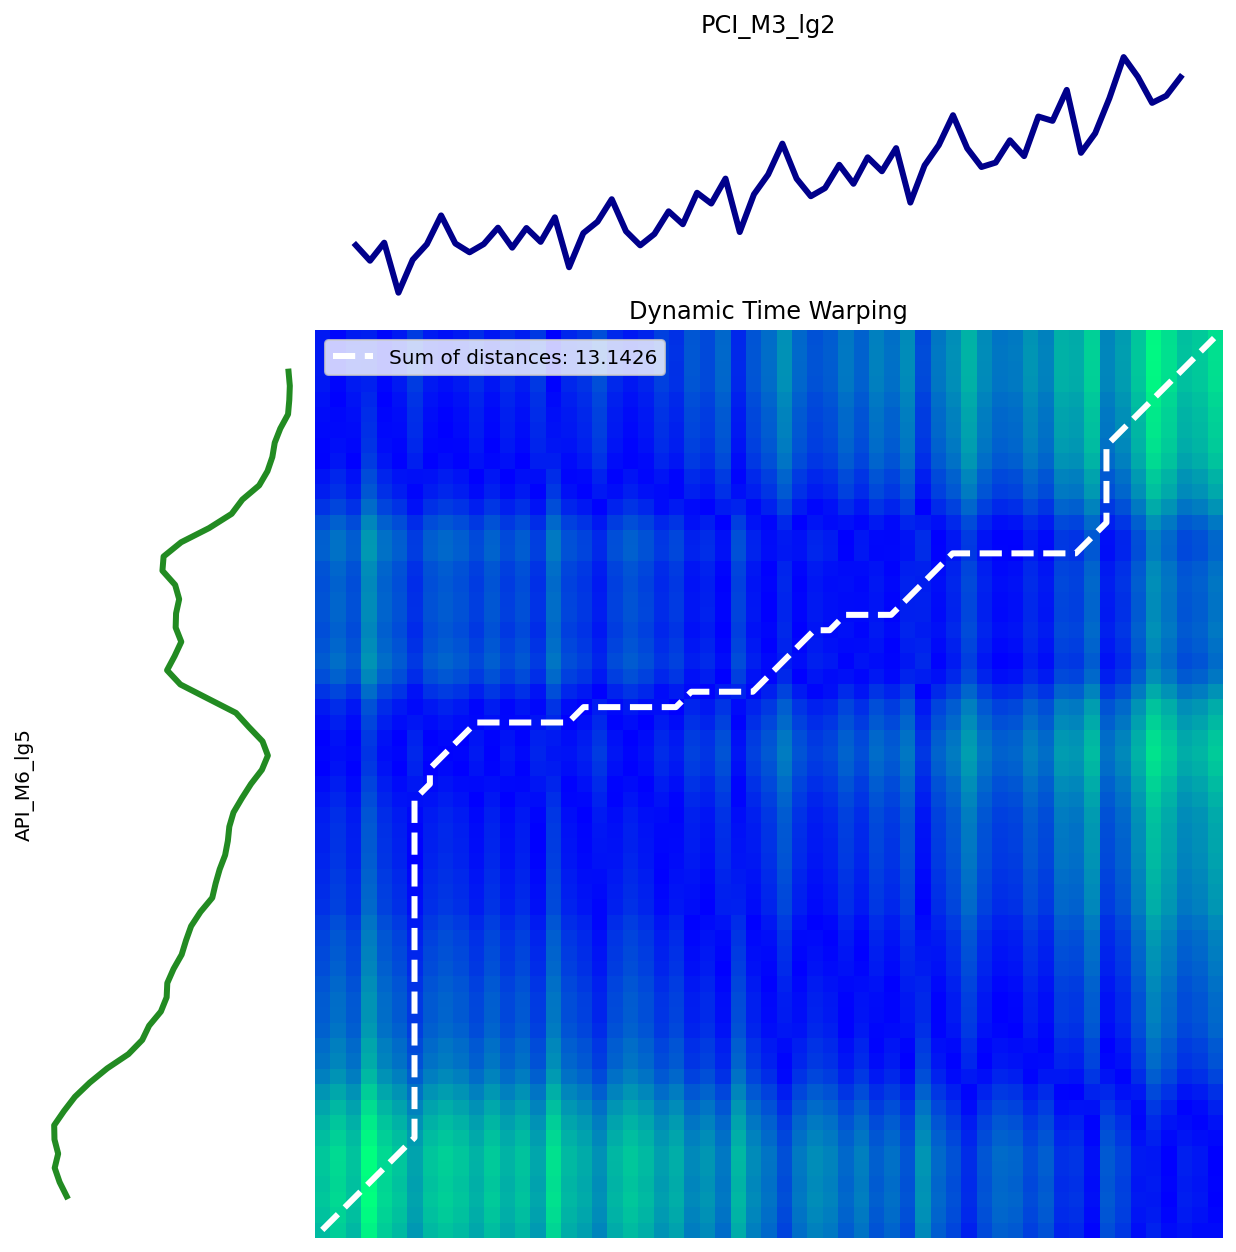

In [ ]:
# Plot (Random)
plotDTW(
    dfPlot.sample(2, axis = 1).iloc[:, 0],
    dfPlot.sample(2, axis = 1).iloc[:, 1]
)

In [ ]:
# Time series K-Means clustering
scores = []

for n in range(1, dfSTD.shape[0]):
  km = TimeSeriesKMeans(
      n_clusters = n,
      metric = 'dtw',
      dtw_inertia = True,
      random_state = 42
  )
  km.fit(dfSTD)
  scores.append(km.inertia_)

# Find best K (Using Kneed)
kneedle = KneeLocator(
    np.arange(1, len(scores) + 1),
    scores,
    S = 1.0,
    curve = 'convex',
    direction = 'decreasing'
)

# Result
nClusters = kneedle.elbow
print(f'Optimum number of cluster by Elbow method: {nClusters}')

Optimum number of cluster by Elbow method: 6


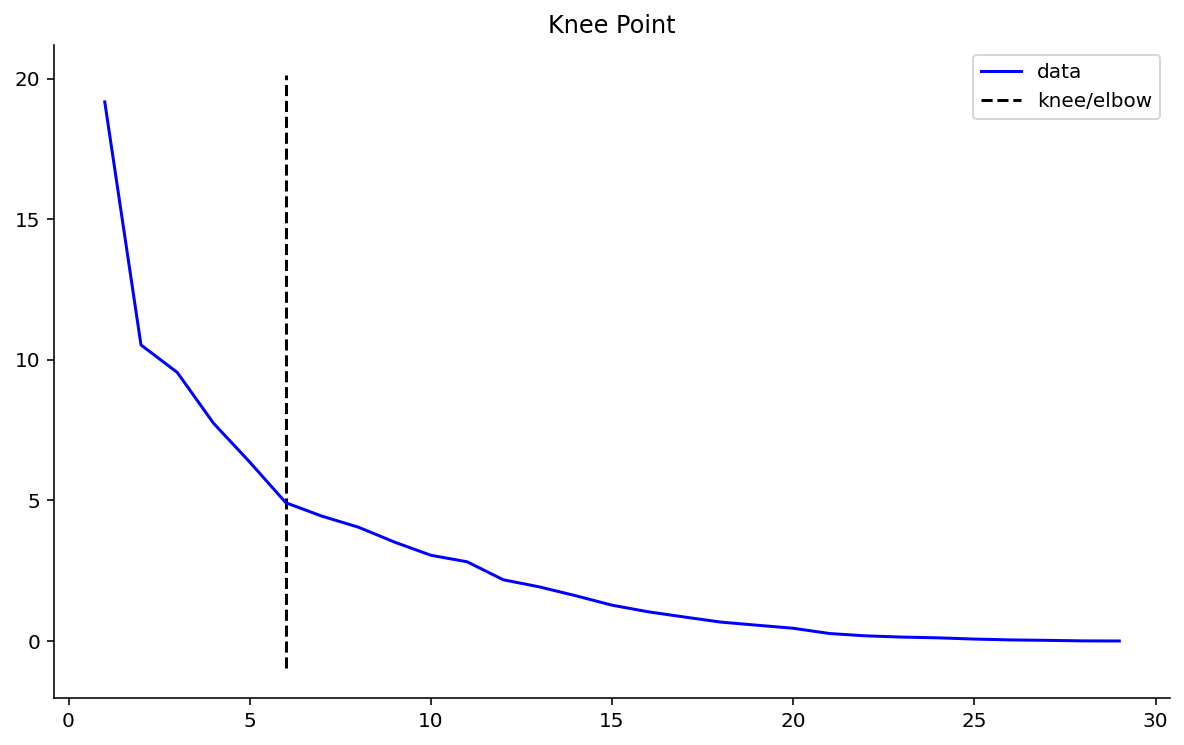

In [ ]:
# Plot
with plt.style.context(plotStyle):
  kneedle.plot_knee(figsize = (10, 6))
plt.show()

In [ ]:
# Time series K-Means clustering
TKMeans = TimeSeriesKMeans(
    n_clusters = nClusters,
    metric = 'dtw',
    random_state = 42
)

# Predict
labels = TKMeans.fit_predict(dfSTD)

In [ ]:
# Mapping result
# Transformed data
dfTransformed = pd.DataFrame(
    dfSTD,
    columns = df.index,
    index = df.columns
)
dfTransformed['Cluster'] = list(labels + 1)
dfTransformed.head(5)

Date,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,Cluster
HD_M9_lg8,-1.9551,-1.8510,-1.7568,-1.6746,-1.5983,-1.5184,-1.4295,-1.3349,-1.2439,-1.1619,-1.0892,-1.0211,-0.9556,-0.8930,-0.8357,-0.7840,-0.7336,-0.6789,-0.6164,-0.5472,-0.4755,-0.4041,-0.3346,-0.2656,-0.1976,-0.1320,-0.0709,-0.0144,0.0410,0.0996,0.1638,0.2315,0.2971,0.3582,0.4148,0.4704,0.5258,0.5790,0.6266,0.6675,0.7059,0.7480,0.7969,0.8502,0.9018,0.9483,0.9900,1.0305,1.0713,1.1114,1.1482,1.1818,1.2161,1.2571,1.3080,1.3667,1.4282,1.4892,1.5487,6
API_lg8,1.9424,1.7848,1.5088,1.6657,1.8272,1.7329,1.6689,2.0769,1.5312,0.8917,0.9639,0.5614,0.2919,0.4027,0.4366,0.3517,0.0311,0.1076,0.2411,-0.0927,-0.2021,0.0073,-0.3692,-0.6294,-0.6949,-0.3558,-0.5229,-0.4236,-0.5848,-0.7445,-1.0245,-1.0188,-1.2394,-1.2892,-1.0541,-0.3231,0.0504,0.0034,0.9590,0.9028,-0.0033,-0.9225,-0.4735,0.4479,0.9272,0.6574,0.3141,0.0815,-0.5643,-0.9369,-1.2851,-1.1199,-0.5308,-1.2467,-1.2204,-1.3225,-1.4725,-1.5601,-1.1418,1
FDI_M9_lg4,-0.9775,-0.9302,-0.9572,-1.0219,-1.0621,-1.0416,-0.9708,-0.8862,-0.8099,-0.7324,-0.6246,-0.4764,-0.3114,-0.1731,-0.0864,-0.0421,-0.0169,0.0065,0.0261,0.0289,0.0019,-0.0615,-0.1610,-0.2926,-0.4454,-0.6029,-0.7509,-0.8780,-0.9751,-1.0324,-1.0388,-0.9832,-0.8668,-0.7089,-0.5416,-0.3921,-0.2782,-0.2089,-0.1797,-0.1692,-0.1497,-0.1029,-0.0310,0.0600,0.1665,0.2977,0.4670,0.6755,0.9021,1.1136,1.2989,1.4796,1.6888,1.9315,2.1687,2.3403,2.4217,2.4390,2.4573,6
CCI_M12_lg5,-0.5861,-0.4085,-0.3443,-0.4010,-0.4690,-0.6050,-0.8203,-1.2132,-1.6817,-2.1200,-2.1464,-1.9802,-1.6779,-1.2661,-0.8921,-0.5483,-0.1478,0.3735,0.9667,1.4389,1.7789,2.1719,2.1907,1.8998,1.5447,1.1518,0.7778,0.5284,0.2640,0.0033,-0.1592,-0.3103,-0.4236,-0.5521,-0.6956,-0.6919,-0.5294,-0.4992,-0.4916,-0.5634,-0.4916,-0.3859,-0.2990,-0.2045,-0.1932,-0.0118,0.1544,0.3357,0.3169,0.4415,0.5662,0.7287,0.7853,0.8533,0.8496,0.9062,1.0309,0.9365,0.8145,2
RSI_LN_lg5,0.1387,-0.1704,-0.3489,-0.2139,0.9084,-0.4787,-0.9160,0.8106,-0.9862,-0.3724,-0.6349,-0.7584,-1.1499,-0.3326,-0.6530,-0.9766,0.7744,-0.9086,-1.1507,0.3971,-1.5127,-1.0188,-0.4916,-0.7949,-0.9544,-0.6523,-0.4201,-0.1732,1.7892,-1.1814,-0.8227,0.9684,-1.4293,-0.3015,-0.0962,-0.8660,-0.4508,-0.5620,-0.9492,-0.0962,1.7001,-0.3319,-0.4430,2.0097,-0.8608,0.8245,0.7249,0.1243,0.9547,0.8396,-0.0857,0.9671,2.3423,1.1065,0.7262,2.5803,0.2763,1.7595,1.8231,4


In [ ]:
# Raw data
dfRaw = pd.DataFrame.copy(df).T
dfRaw['Cluster'] = list(labels + 1)
dfRaw.head(5)

Date,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01,2015-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,Cluster
HD_M9_lg8,7714968.7399,7797697.6288,7872636.9608,7937978.0217,7998612.0217,8062163.2778,8132822.9184,8207993.8073,8280322.6369,8345568.2465,8403359.0243,8457458.9871,8509556.4918,8559331.1584,8604851.6641,8645993.3451,8686072.7896,8729530.1791,8779216.7204,8834194.4982,8891208.1935,8947972.6707,9003226.5596,9058122.6465,9112184.5733,9164338.5733,9212906.2581,9257816.7915,9301820.7915,9348424.5420,9399446.9628,9453246.9628,9505477.6067,9553978.6971,9598981.2526,9643191.5466,9687214.3823,9729577.7157,9767359.8753,9799883.6205,9830434.5094,9863877.6557,9902782.7568,9945161.3124,9986191.0122,10023164.5099,10056328.2876,10088513.2115,10120901.4884,10152786.0439,10182088.6471,10208748.2535,10236059.4757,10268642.0366,10309086.1602,10355744.7158,10404659.8082,10453164.5352,10500423.4241,6
API_lg8,154.2877,152.9524,150.6148,151.9438,153.3119,152.5132,151.9708,155.4271,150.8047,145.3879,146.0001,142.5904,140.3075,141.2463,141.5330,140.8147,138.0990,138.7465,139.8774,137.0498,136.1236,137.8976,134.7083,132.5045,131.9493,134.8214,133.4063,134.2473,132.8824,131.5290,129.1578,129.2063,127.3378,126.9157,128.9071,135.0985,138.2623,137.8643,145.9583,145.4824,137.8074,130.0221,133.8248,141.6291,145.6890,143.4033,140.4961,138.5258,133.0559,129.8999,126.9508,128.3501,133.3396,127.2755,127.4982,126.6336,125.3629,124.6216,128.1639,1
FDI_M9_lg4,190907.6223,191517.8708,191168.9390,190333.3723,189814.3580,190079.1249,190993.4949,192087.0207,193071.6328,194072.7483,195465.8596,197379.0442,199511.2942,201297.2472,202416.9543,202989.2999,203314.3737,203616.6561,203870.0861,203905.8429,203558.2551,202738.5518,201453.2310,199753.3602,197780.2979,195745.7540,193833.9526,192192.1381,190938.2694,190198.3356,190115.0767,190833.6171,192336.7982,194377.0938,196537.5204,198468.0986,199940.0120,200834.6148,201212.4974,201347.6097,201599.2836,202204.2362,203132.6162,204307.8941,205683.5615,207377.9537,209565.4009,212257.6739,215185.5905,217916.7537,220310.9802,222644.4846,225346.8028,228481.3605,231545.1393,233761.7715,234812.5743,235036.5809,235272.9817,6
CCI_M12_lg5,36.2083,36.6000,36.7417,36.6167,36.4667,36.1667,35.6917,34.8250,33.7917,32.8250,32.7667,33.1333,33.8000,34.7083,35.5333,36.2917,37.1750,38.3250,39.6333,40.6750,41.4250,42.2917,42.3333,41.6917,40.9083,40.0417,39.2167,38.6667,38.0833,37.5083,37.1500,36.8167,36.5667,36.2833,35.9667,35.9750,36.3333,36.4000,36.4167,36.2583,36.4167,36.6500,36.8417,37.0500,37.0750,37.4750,37.8417,38.2417,38.2000,38.4750,38.7500,39.1083,39.2333,39.3833,39.3750,39.5000,39.7750,39.5667,39.2977,2
RSI_LN_lg5,5.4007,5.3804,5.3687,5.3775,5.4512,5.3602,5.3315,5.4448,5.3269,5.3671,5.3499,5.3418,5.3161,5.3698,5.3487,5.3275,5.4424,5.3319,5.3161,5.4177,5.2923,5.3247,5.3593,5.3394,5.3289,5.3488,5.3640,5.3802,5.5090,5.3140,5.3376,5.4552,5.2978,5.3718,5.3853,5.3347,5.3620,5.3547,5.3293,5.3853,5.5032,5.3698,5.3625,5.5235,5.3351,5.4457,5.4392,5.3997,5.4543,5.4467,5.3860,5.4551,5.5453,5.4642,5.4393,5.5610,5.4097,5.5071,5.5112,4


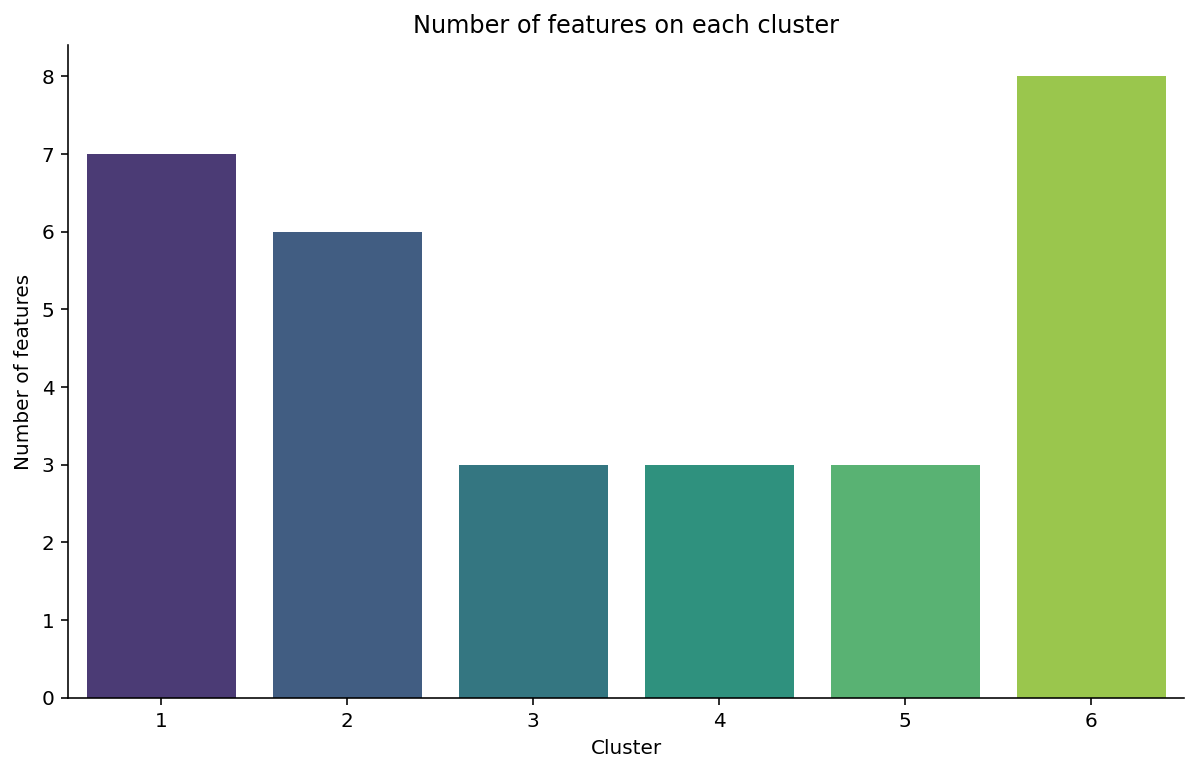

In [ ]:
# Count cluster
plt.figure(figsize = (10, 6))
with plt.style.context(plotStyle):
  sns.countplot(
      x = 'Cluster',
      data = dfRaw,
      palette = 'viridis'
  )
  plt.title('Number of features on each cluster')
  plt.ylabel('Number of features')
plt.show()

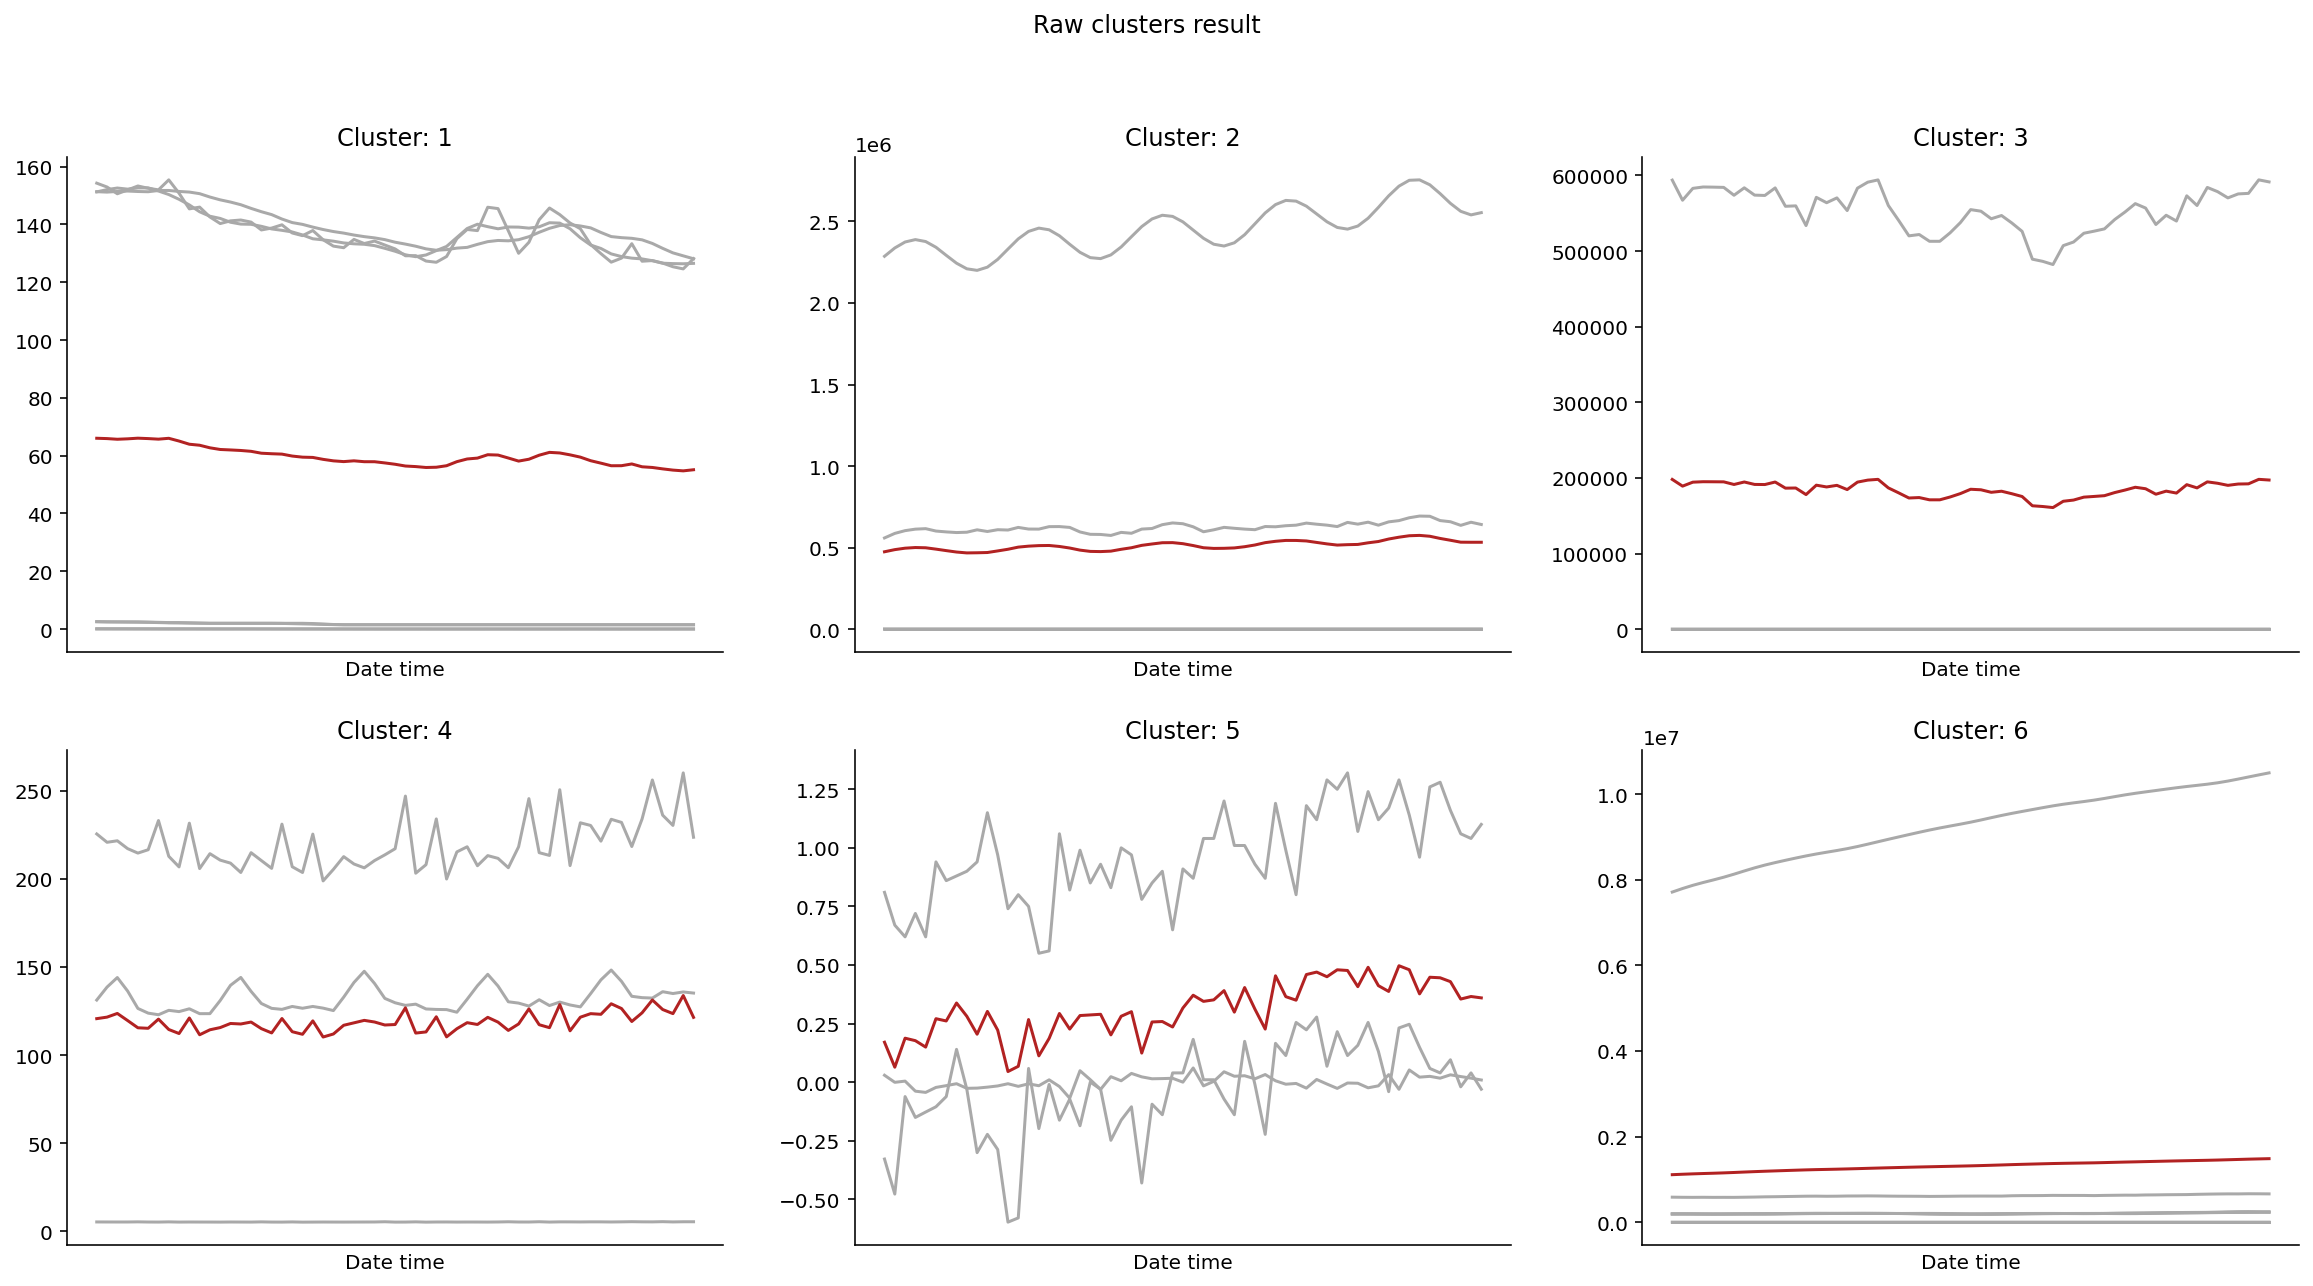

In [ ]:
# Define plot function
def plotResult(data, title):
  with plt.style.context(plotStyle):
    fig, axs = plt.subplots(
        2, 3,
        figsize = (20, 10), 
        sharex = True
    )
    axs = axs.ravel()
    fig.suptitle(f'{title}')
    for i, cluster in enumerate(sorted(data['Cluster'].unique())):
      dataPlot = data.query(
          "Cluster == @cluster"
      ).drop(
          ['Cluster'], axis = 1
      ).T
      dataMeanPlot = dataPlot.mean(axis = 1)
      axs[i].plot(dataPlot, color = 'darkgray')
      axs[i].plot(dataMeanPlot, color = 'firebrick')
      axs[i].set_title(f'Cluster: {cluster}')
      axs[i].set_xticks([])
      axs[i].set(xlabel = 'Date time', ylabel = '')
  return plt.show()

# Plot
plotResult(dfRaw, 'Raw clusters result')

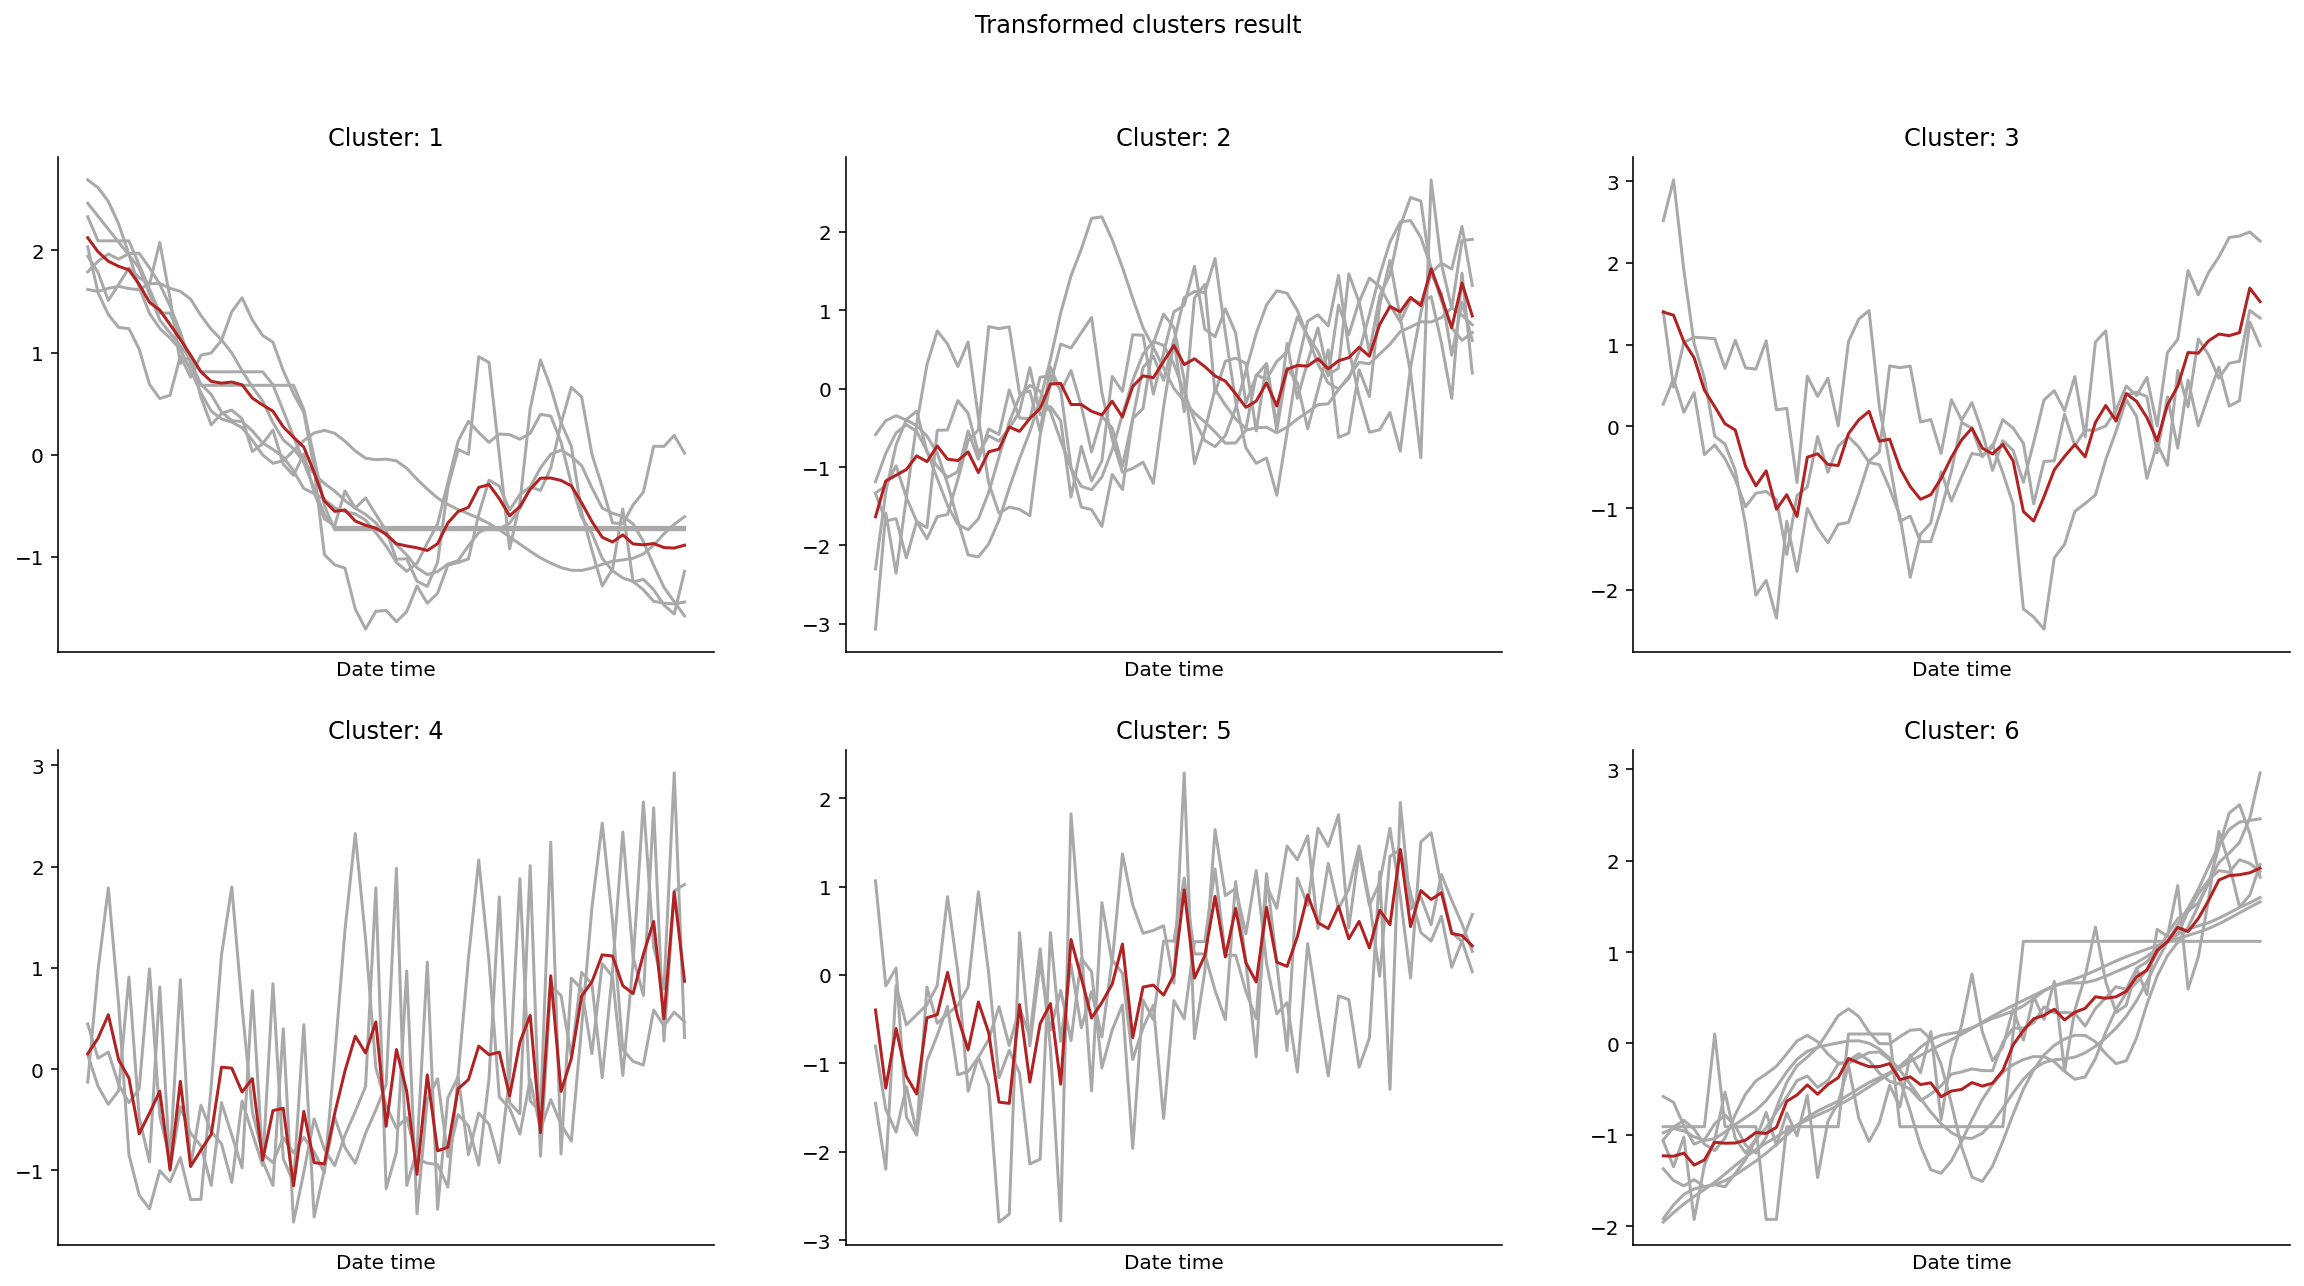

In [ ]:
# Plot
plotResult(dfTransformed, 'Transformed clusters result')

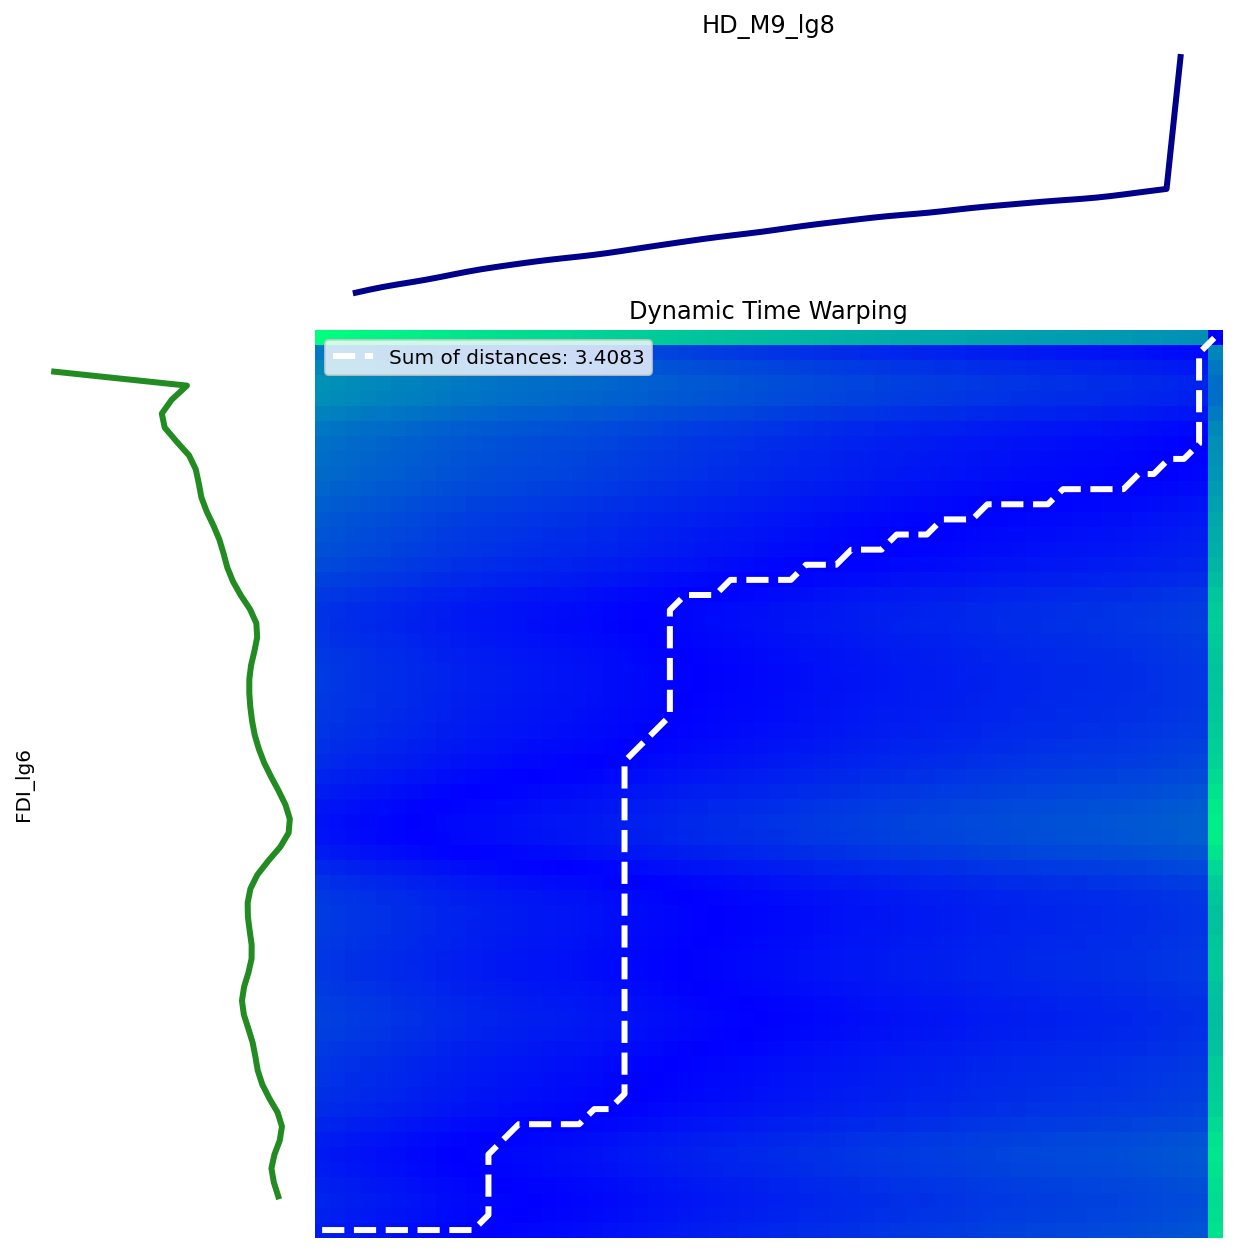

In [ ]:
# Plot sample DTW from same cluster == 6
plotDTW(
    dfTransformed.query("Cluster == 6").sample(2).iloc[0, :],
    dfTransformed.query("Cluster == 6").sample(2).iloc[1, :]
)

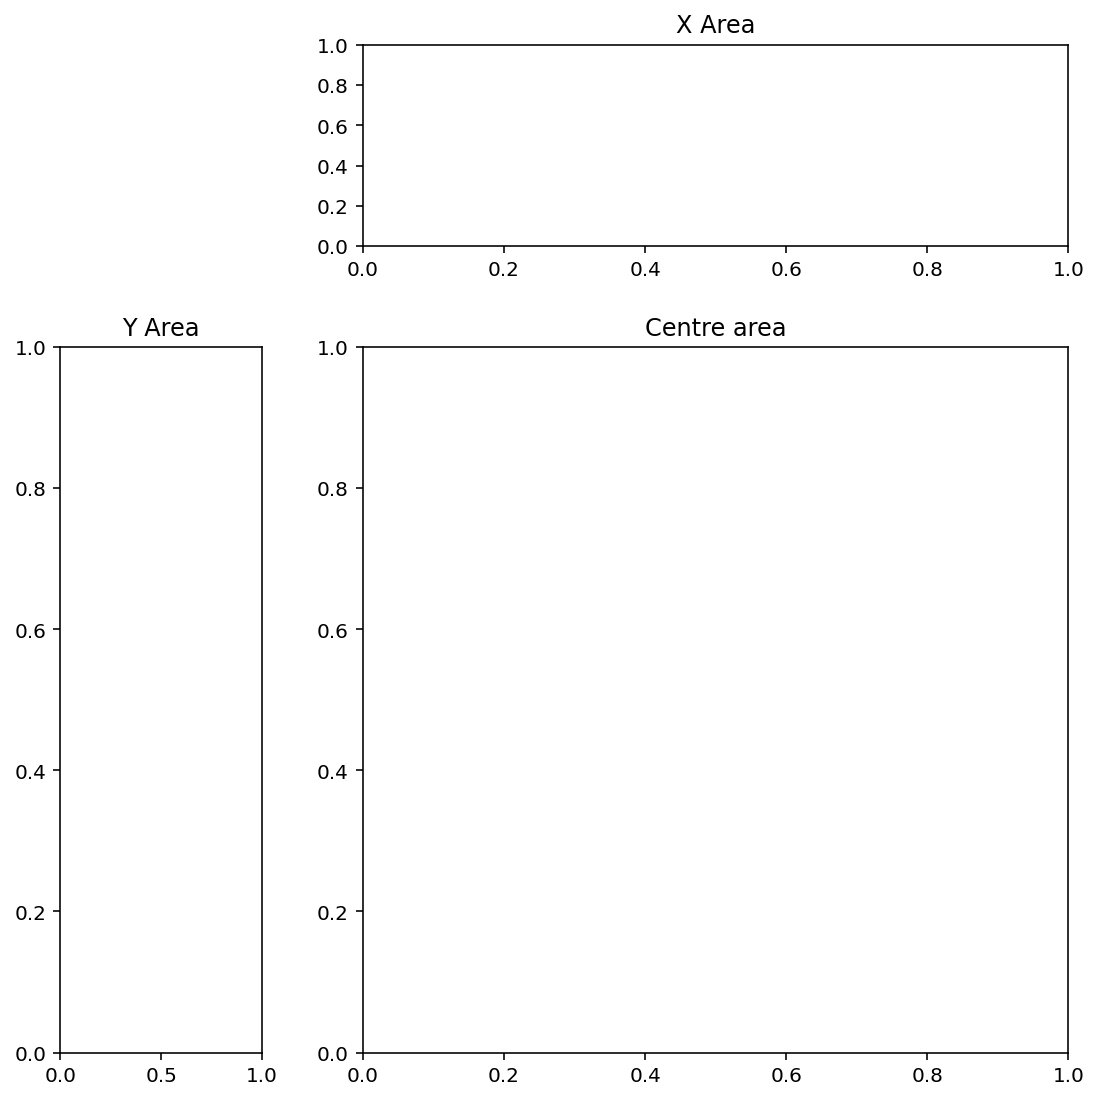

In [ ]:
# Note for plot area
plt.figure(1, figsize = (7, 7))
axDist = plt.axes([0.3, 0, 0.7, 0.7])
axX = plt.axes([0.3, 0.8, 0.7, 0.2])
axY = plt.axes([0, 0, 0.2, 0.7])
axDist.set_title('Centre area')
axX.set_title('X Area')
axY.set_title('Y Area')
plt.show()